# Kerasを用いた画像分類入門

Kerasを用いて、画像分類モデルを作ってみます。

今回は、「ラーメン」と「うどん」の2つの画像を分類する学習モデルを作成します。
画像分類でよく使われる、畳み込みニューラルネットワーク (CNN) は使用せず、まずは単純なニューラルネットワークのみで分類してみましょう。

## 流れ

1. データの取得
2. データの選別
3. モデルの構築
4. 学習
5. 推論


## 1. データの取得



今回はインターネットにある画像を収集して、使用します。
インターネットから画像などの情報を収集する場合は、専用のサービス (API) を使用する方法と、
HTMLドキュメントを解析するWebスクレイピングによる方法があります。
今回は専用のサービスを使用する方法で、画像を収集します。

今回使用するサービスは、Microsoftが提供している、「Bing Image Search API」を使用します。
このAPIを使用して、インターネットに公開されている「ラーメン」と「うどん」の画像を収集します。

取得スクリプトについては、[bing_image_search_downloder.ipynb](./bing_image_search_downloder.ipynb)のノートブックを参照してください。

## 2. データの選別

データを取得したら、データを選別する必要があります。例えば、「ラーメン」で画像検索した結果には、ラーメンそのものの画像以外にも検索結果に入ってきます。

![ラーメン検索結果](./images/bing_ramen_search.png "ラーメン検索結果")

このように、学習に必要ない画像を取り除く必要があります。
今回はラーメンやうどんには関係なさそうな画像も一部学習データに混ざった状態になっていますが、そのまま学習のデータとして使用します。

また、取得したデータを学習するため、以下の3つのディレクトリに分けて保存します。

- train
    - モデルの学習に使用します。
- verification
    - モデルの学習中に、未知のデータに対してどれだけ精度が上がっているかを検証するためにしようします。
- test
    - モデルの学習が終わった後で、実際の推論時に使用します。

ラーメン、うどん各々の画像に対して、trainデータ300件、verificationデータ100件、testデータ100件ずつ格納していきます。

画像の保存フォルダには、以下のようになっています。

```
noodles
├── test
│   ├── ramen
│   │   ├── 007a9f3ee253e4e00e91a86f79d96251.jpg
│   │   ├── 01b2931a076face741042e491d03d03c.jpg
│   │   ├── 047a34512b2f554df476f924956d9324.jpg
│   │   ├── 11cb359269c9b59de1c150e4a21b6266.jpg
│   │   ├── 12521618a6169010cfdfa319b2cd66a6.jpg
│   │
│   │
│   └── udon
│       ├── 018e203f3bb9cfd9b407e90a2f975d30.jpg
│       ├── 0543055a3987c79c07b6abdbcd608cd6.jpg
│       ├── 094c1922e08cbd1fc5c890309a73c91a.jpg
│       ├── 111d37eb4ac7cfa268001133857db4ec.jpg
│       ├── 111ec27a535af2c06a32726a63c0629e.jpg
│
│   
├── train
│   ├── ramen
│   │   ├── 01375acfef42ca0296d994319ab370d5.jpg
│   │   ├── 02f5f33eaa99f544d1b56dd43acc12e7.jpg
│   │   ├── 03477d329e51964eca3d5350513bdc5b.jpg
│   │   ├── 03da108a718435ed77080f050bac7733.jpg
│   │   ├── 061bf905ebbba6fd7719ac3322b34f9b.jpg
│   │
│   │
│   └── udon
│       ├── 0008ccb95ea65115c9c91b973fa3d13a.jpg
│       ├── 025e6f3e0c0426c4b88737621854453f.jpg
│       ├── 02608a29fe16132807e9cbfc15a40703.jpg
│       ├── 038d39af3f843334906a0c559c2eeb64.jpg
│       ├── 047262dd8a3f5e1822aa10a828fd6433.jpg
│
│
└── validaiton
    ├── ramen
    │   ├── 0220d9d1e8bf2906553a81e29e08e24b.png
    │   ├── 03f8f134736f585014a340f5e9e147d1.jpg
    │   ├── 04d9bfe2d8437ed5072f2f183ad41511.jpg
    │   ├── 086cde8b41aef5076d51d73dc8d601e1.jpg
    │   ├── 08f78c8e2e53989a68d7e3b864bd579f.jpg
    │
    │
    └── udon
        ├── 0035a169051a0afbd792f30a82934a3e.jpg
        ├── 005b96c51ae7adbc7acc5c4e4a790fbb.jpg
        ├── 06078751ab342a44bedc08e235d5ef5c.jpg
        ├── 0ba18a8a8b878dd11c7076f0f71cda63.jpg
        ├── 0d3486e1682132d6bdd36a623dde48a4.jpg


```

APIで取得した画像を上記のディレクトリに格納するスクリプトは、[copy_to_train_validation_test.ipynb](./copy_to_train_validation_test.ipynb)を参照ください。

### Google Colaboratoryでの設定 (学習データのコピー)

In [ ]:
# Google Colabを利用されている方は、以下のコマンドを利用してGoogle Driveをマウントし、
# noodles.zipファイルをColabコンテナにコピーしておきましょう。
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip /content/gdrive/My\ Drive/GD_share01/noodles.zip -d /content

## 3. モデルの構築

さてここで、実際にKerasを使ってディープラーニングの学習モデルを構築していきます。
まずは、単純な全結合層を3つほど使った多層ニューラルネットワークモデルを作っていきましょう。

### 入力データの生成

画像ファイルが格納されたディレクトリからデータを読み込んで、学習モデルに入力するための準備を行います。

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './noodles/train/'
validation_dir = './noodles/validaiton/'
test_dir = './noodles/test/'

image_size = (128, 128)  # 入力データの縦横のサイズ。画像ファイルはこのサイズに自動的にリサイズされる。
batch_size = 32  # バッチサイズ。1度に取り込む入力データの数。

image_data_generator = ImageDataGenerator(rescale=1/255.0)
# 画像データはRGBの値が0から255までの値になっているので、
# rescaleして値を0から1までの範囲にすることで、学習の収束を早くする。

train_generator = image_data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size
)
validation_generator = image_data_generator.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size
)
test_generator = image_data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size
)

### モデルの構築

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(128,128,3)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

### モデルのコンパイル

学習モデルに対して、損失関数、オプティマイザ、評価方法を設定し、コンパイルします。

In [ ]:
model.compile(
    loss='categorical_crossentropy',   # 今回は「多クラス分類」を扱うため、損失関数を「categorical_crossentropy」に設定する
    optimizer='adam',  # オプティマイザに「Adam」を使用
    metrics=['acc']  # 評価方法は「正答率」 (accuracy)
)

## 4. 学習

構築したモデルを実際に学習していきます。

In [ ]:
epochs = 10  # エポック数。全ての入力データを何回繰り返して学習するかを指定する。
train_steps = 300 // batch_size    # エポックあたりのステップ数。
validation_steps = 100 // batch_size
test_steps = 100 // batch_size

In [ ]:
# 学習
# 学習の推移を、historyに格納しておく
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

In [ ]:
# 学習の推移をグラフ化してみてみよう。
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']  # 学習データの正答率
val_acc = history.history['val_acc']  # 検証データの正答率
loss = history.history['loss']  # 学習データの損失
val_loss = history.history['val_loss']  # 検証データの損失

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# 学習モデルを保存
model.save('noodle_model1.h5')


## 5. 推論

学習済モデルを使って、テストデータを推論してみましょう。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

code_to_class = {0: 'ラーメン', 1: 'うどん'}

x, y = next(test_generator)
y_true = np.argmax(y, axis=1)
y_prob = model.predict_on_batch(x)
y_pred = np.argmax(y_prob, axis=1)

for i in range(len(x)):
    plt.imshow(x[i])
    plt.show()
    print('推定：', code_to_class[y_pred[i]])
    print('正解：', code_to_class[y_true[i]])

In [ ]:
# 混同行列で見てみる
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

混同行列は、以下のような内容になっています。

|↓教師データ ／ 出力結果→| 0: ラーメン | 1: うどん |
|:---|:---|:---|
|0: ラーメン|正しくラーメンと判定した|ラーメンなのに、うどんと判定した|
|1: うどん|うどんなのに、ラーメンと判定した|正しくうどんと判定した|

## 畳込みニューラルネットワークを構築する

全結合層のみのネットワークは精度がいいとは言えませんね。
そこで、先ほどのモデルを改良して、今度は畳込みニューラルネットワークを構築します。

### 入力データの生成

先ほどと同じです。

In [1]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './noodles/train/'
validation_dir = './noodles/validaiton/'
test_dir = './noodles/test/'

image_size = (128, 128)  # 入力データの縦横のサイズ。画像ファイルはこのサイズに自動的にリサイズされる。
batch_size = 32  # バッチサイズ。1度に取り込む入力データの数。

image_data_generator = ImageDataGenerator(rescale=1/255.0)
# 画像データはRGBの値が0から255までの値になっているので、
# rescaleして値を0から1までの範囲にすることで、学習の収束を早くする。

train_generator = image_data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size
)
validation_generator = image_data_generator.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size
)
test_generator = image_data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size
)

Using TensorFlow backend.


Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### モデルの構築

畳込み層である「Conv2D」とプーリング層である「MaxPool2D」を追加しています。

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D

model = Sequential()

model.add(Conv2D(32, (3,3), strides=(1,1), activation='relu', input_shape=(128,128,3)))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
__________

モデルのコンパイル以降の処理は同じです。

In [4]:
model.compile(
    loss='categorical_crossentropy',   # 今回は「多クラス分類」を扱うため、損失関数を「categorical_crossentropy」に設定する
    optimizer='adam',  # オプティマイザに「Adam」を使用
    metrics=['acc']  # 評価方法は「正答率」 (accuracy)
)

In [12]:
epochs = 20  # エポック数。全ての入力データを何回繰り返して学習するかを指定する。
train_steps = 300 // batch_size    # エポックあたりのステップ数。
validation_steps = 100 // batch_size
test_steps = 100 // batch_size

In [13]:
# 学習
# 学習の推移を、historyに格納しておく
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/20
9/9 [==============================] - 17s 2s/step - loss: 0.3891 - acc: 0.8235 - val_loss: 0.7280 - val_acc: 0.6250
Epoch 2/20
9/9 [==============================] - 15s 2s/step - loss: 0.3317 - acc: 0.8542 - val_loss: 0.7005 - val_acc: 0.6771
Epoch 3/20
9/9 [==============================] - 13s 1s/step - loss: 0.1953 - acc: 0.9178 - val_loss: 0.8831 - val_acc: 0.7292
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.2902 - acc: 0.9028 - val_loss: 0.6242 - val_acc: 0.7639
Epoch 5/20
9/9 [==============================] - 15s 2s/step - loss: 0.1865 - acc: 0.9387 - val_loss: 1.0075 - val_acc: 0.6458
Epoch 6/20
9/9 [==============================] - 14s 2s/step - loss: 0.1615 - acc: 0.9236 - val_loss: 1.4114 - val_acc: 0.6389
Epoch 7/20
9/9 [==============================] - 14s 2s/step - loss: 0.2014 - acc: 0.9084 - val_loss: 1.2840 - val_acc: 0.6771
Epoch 8/20
9/9 [==============================] - 15s 2s/step - loss: 0.2515 - acc: 0.8924 - val_loss: 0

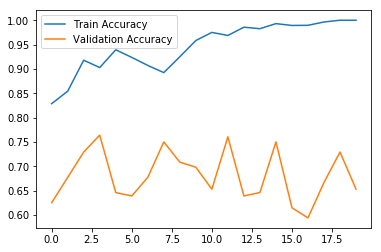

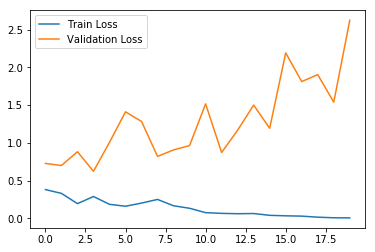

In [14]:
# 学習の推移をグラフ化してみてみよう。
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']  # 学習データの正答率
val_acc = history.history['val_acc']  # 検証データの正答率
loss = history.history['loss']  # 学習データの損失
val_loss = history.history['val_loss']  # 検証データの損失

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [15]:
# 学習モデルを保存
model.save('noodle_model2.h5')

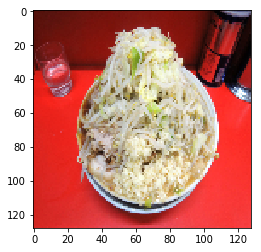

推定： ラーメン
正解： ラーメン


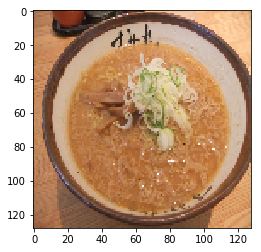

推定： ラーメン
正解： ラーメン


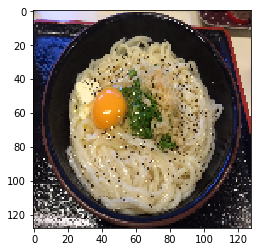

推定： うどん
正解： うどん


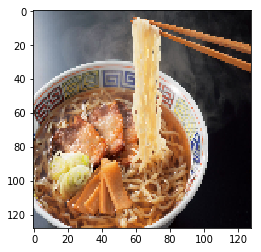

推定： うどん
正解： ラーメン


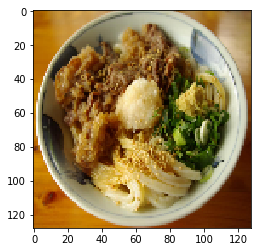

推定： ラーメン
正解： うどん


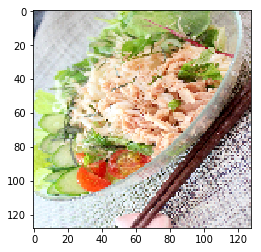

推定： うどん
正解： うどん


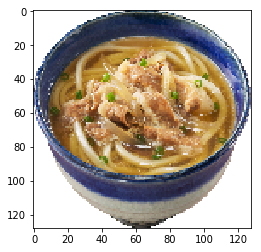

推定： うどん
正解： うどん


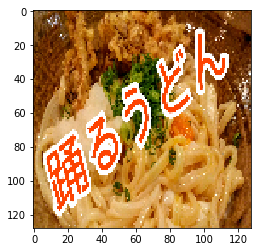

推定： ラーメン
正解： うどん


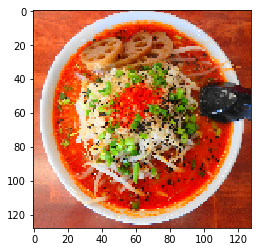

推定： ラーメン
正解： ラーメン


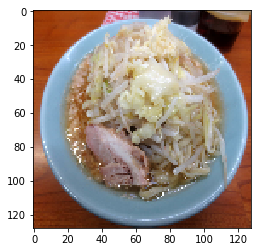

推定： ラーメン
正解： ラーメン


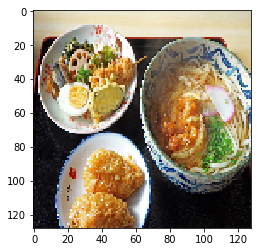

推定： うどん
正解： うどん


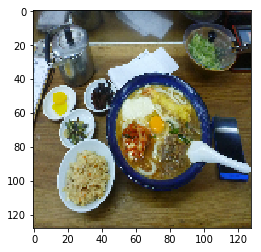

推定： うどん
正解： うどん


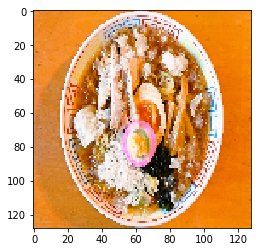

推定： ラーメン
正解： ラーメン


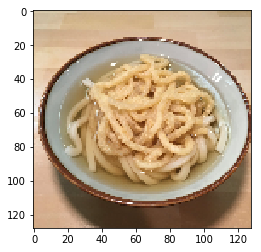

推定： ラーメン
正解： うどん


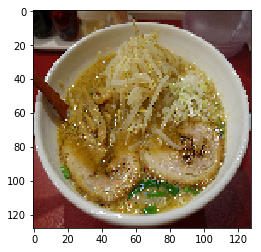

推定： ラーメン
正解： ラーメン


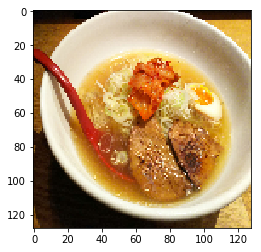

推定： ラーメン
正解： ラーメン


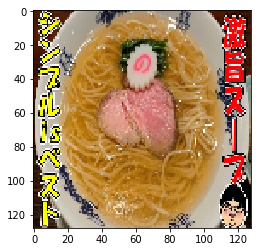

推定： うどん
正解： ラーメン


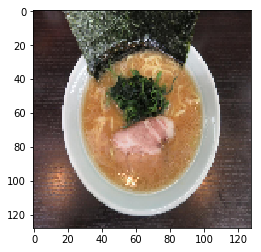

推定： ラーメン
正解： ラーメン


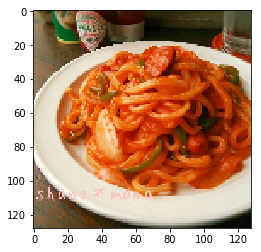

推定： ラーメン
正解： うどん


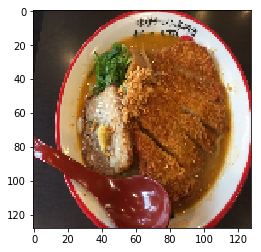

推定： うどん
正解： ラーメン


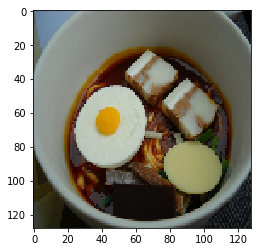

推定： うどん
正解： ラーメン


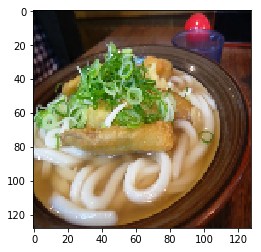

推定： ラーメン
正解： うどん


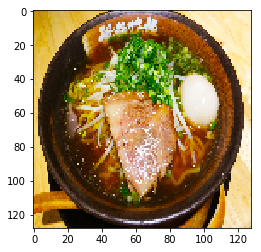

推定： うどん
正解： ラーメン


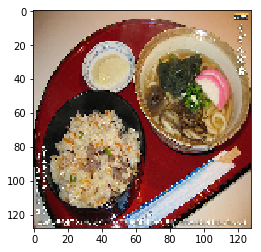

推定： うどん
正解： うどん


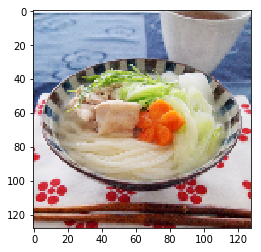

推定： うどん
正解： うどん


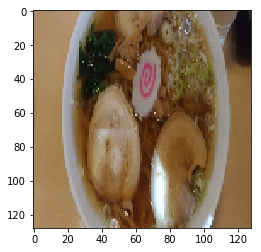

推定： うどん
正解： ラーメン


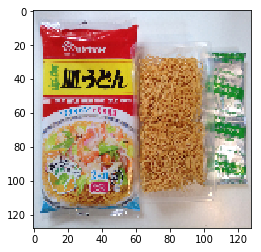

推定： うどん
正解： うどん


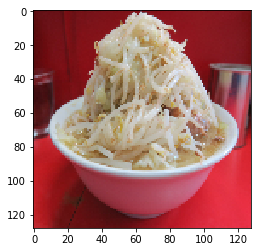

推定： ラーメン
正解： ラーメン


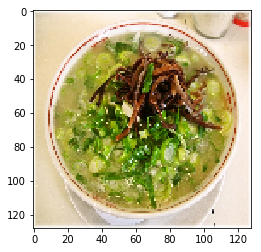

推定： うどん
正解： ラーメン


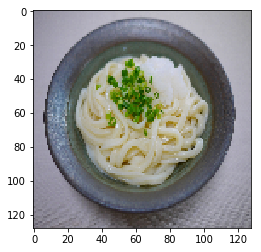

推定： うどん
正解： うどん


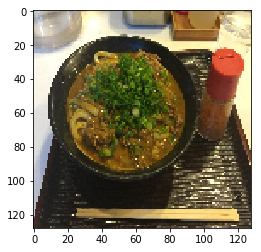

推定： うどん
正解： うどん


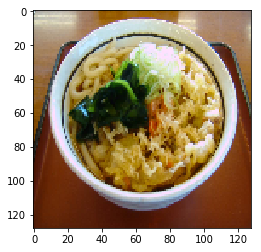

推定： ラーメン
正解： うどん


In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

code_to_class = {0: 'ラーメン', 1: 'うどん'}

x, y = next(test_generator)
y_true = np.argmax(y, axis=1)
y_prob = model.predict_on_batch(x)
y_pred = np.argmax(y_prob, axis=1)

for i in range(len(x)):
    plt.imshow(x[i])
    plt.show()
    print('推定：', code_to_class[y_pred[i]])
    print('正解：', code_to_class[y_true[i]])

In [17]:
predictions = model.predict_generator(test_generator, steps=test_steps)

print(predictions)

[[2.2065256e-05 9.9997795e-01]
 [7.9484987e-01 2.0515014e-01]
 [9.9986267e-01 1.3734364e-04]
 [9.9998510e-01 1.4944367e-05]
 [1.2284917e-05 9.9998772e-01]
 [2.6869566e-11 1.0000000e+00]
 [9.9999988e-01 1.5095736e-07]
 [2.9806371e-03 9.9701935e-01]
 [9.9459225e-01 5.4077459e-03]
 [1.8199438e-05 9.9998176e-01]
 [9.9999988e-01 8.7513186e-08]
 [9.9999642e-01 3.5839430e-06]
 [9.9999869e-01 1.3024106e-06]
 [9.9892336e-01 1.0766530e-03]
 [2.6990314e-08 1.0000000e+00]
 [2.1437008e-06 9.9999785e-01]
 [3.7225413e-03 9.9627739e-01]
 [9.9999952e-01 4.8279577e-07]
 [1.2083316e-04 9.9987912e-01]
 [9.9896336e-01 1.0366386e-03]
 [1.0718152e-01 8.9281845e-01]
 [1.7885001e-04 9.9982113e-01]
 [9.8756754e-01 1.2432459e-02]
 [2.2432975e-04 9.9977571e-01]
 [9.9915528e-01 8.4467337e-04]
 [2.7540815e-03 9.9724591e-01]
 [9.9696261e-01 3.0374138e-03]
 [2.3263406e-13 1.0000000e+00]
 [9.4392067e-01 5.6079343e-02]
 [2.8870115e-09 1.0000000e+00]
 [2.8429326e-07 9.9999976e-01]
 [7.3218200e-04 9.9926788e-01]
 [9.8631

In [10]:
# 混同行列で見てみる
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

ModuleNotFoundError: No module named 'sklearn'

## もっと精度を上げるには？

もっと精度を上げるには、以下の方法が考えられます。

- データの数を増やす
    - 学習データの数を300→1,000に増やしてみる
- エポック数を増やす
    - エポック数を10→50に増やしてみる
- 層を増やしてみる
    - 全結合層などの層の数を増やしてみる
- カーネル(フィルタ)の数を増やしてみる
    - 畳み込み層のカーネルの数を増やしてみる
- データ拡張(data augmentation)を行い、データを水増しする
    - KerasのImageDataGeneratorのオプションを使って、画像をランダムに変形させて水増ししてみる
- Dropoutなどを用いて過学習を抑制してみる
    - Dropoutや正則化などの手法を用いて、過学習を防ぐ
- 著名なモデルを使用する
    - Kerasでは、よく使うモデルを簡単に利用できる
    - 代表的なモデル:
        - VGG16 / VGG19
        - ResNet
    - 詳細はKerasのサイトをご確認ください。 [https://keras.io/ja/applications/](https://keras.io/ja/applications/)
- すでに学習済みの著名なモデルを使用し、転移学習／ファインチューニングをする
    - 学習済みモデルを使用し、こちらでカスタマイズして利用すると、少ないデータ数でも精度の良いモデルが出来上がることが多い。


### 参考

昨年開催された「第57回 長岡IT開発者勉強会」(NDS)にて、Kerasを使った画像分類を紹介しています。新潟の名産品4種の画像を分類するために、VGG16をファインチューニングして学習しています。

- スライド資料: [https://speakerdeck.com/kasacchiful/nds57](https://speakerdeck.com/kasacchiful/nds57)
- ノートブック: [https://github.com/kasacchiful/nds57-sample/blob/master/nds57_vgg16_sample.ipynb](https://github.com/kasacchiful/nds57-sample/blob/master/nds57_vgg16_sample.ipynb)
